In [2]:
import pandas as pd
from db import Database
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
import matplotlib.colors as mpcolors

db = Database()

In [3]:

def get_df(db: Database, mwname, pcap_id, g: bool, pt: str, slot_h=1.0, nn=1, max_slots_h=0):

    if g:
        if pt == 'q':
            where = 'rn_qr=1 and is_r is false'
        elif pt == 'r':
            where = 'rn_qr=1 and is_r is true'
        elif pt == 'ok':
            where = 'rn_qr_rcode=1 and rcode = 0'
        elif pt == 'nx':
            where = 'rn_qr_rcode=1 and rcode = 3'
    else:
        if pt == 'q':
            where = 'is_r is false'
        elif pt == 'r':
            where = 'is_r is true'
        elif pt == 'ok':
            where = 'rcode = 0'
        elif pt == 'nx':
            where = 'rcode = 3'


    slot_seconds = 3600 * slot_h
    upper_where = ''
    if max_slots_h > 0:
        max_slots_time = max_slots_h/slot_h
        upper_where = f' and FLOOR(time_s_translated / {slot_seconds}) < {max_slots_time}'
        pass

    if pcap_id:
        df = pd.read_sql(f"""
        SELECT EPS{nn} < 0.5 AS pn, EPS{nn} >= 0.5 AS pp, time_s_translated, FLOOR(time_s_translated / {slot_seconds}) as "hour" from public.get_message_pcap_all3({pcap_id},0)
        where {where} {upper_where}
        """, db.engine)
    else:
        df = pd.read_sql(f"""
        SELECT EPS{nn} < 0.5 AS pn, EPS{nn} >= 0.5 AS pp, time_s_translated, FLOOR(time_s_translated / {slot_seconds}) as "hour" from public.get_message_healthy_all2()
        where {where} {upper_where}
        """, db.engine)

    df = df.groupby("hour").aggregate({"pn": "sum", "pp": 'sum'})

    df.index.name = 'slot'

    df.index = df.index - df.index.min()

    df = df.reindex(pd.Index(range(int(df.index.max()))), fill_value=0)

    df.index.name = 'slot'

    df = df.reset_index()

    if any(df.slot.value_counts() > 1):
        raise Exception('Some values are duplicated.')
    
    return df

In [76]:
dfs = {
    'healthy': get_df(db, 'healthy', None, True, 'nx', slot_h=1),
    'caphaw': get_df(db, 'caphaw', 54, True, 'nx', slot_h=1),
    'zbot': get_df(db, 'zbot', 46, True, 'nx', slot_h=1),
    'simda': get_df(db, 'simda', 58, True, 'nx', slot_h=1),
    'unknown': get_df(db, 'unknown', 57, True, 'nx', slot_h=1)
}

Text(0.5, -0.01, 'hours')

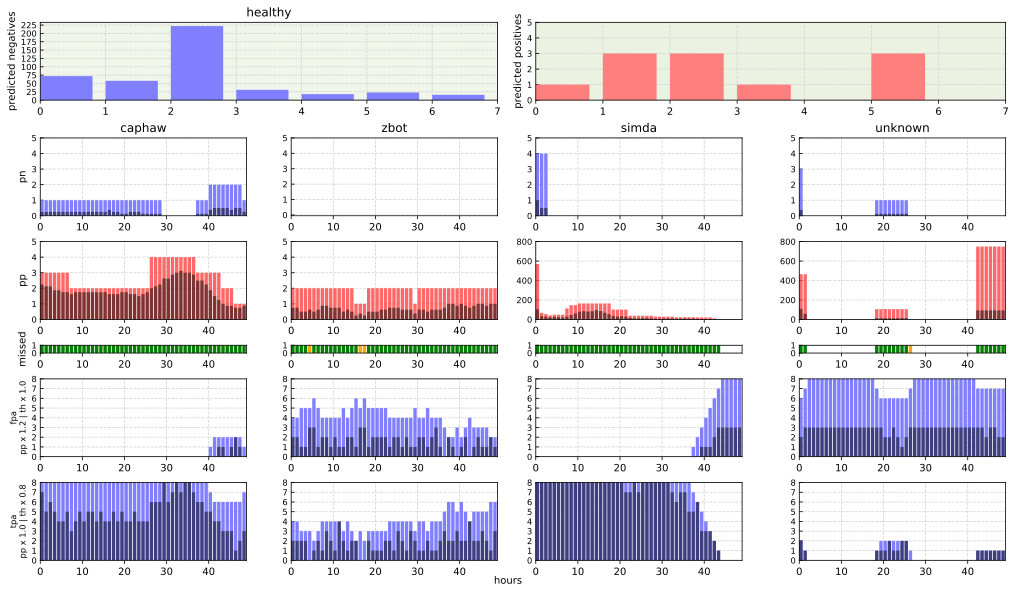

In [101]:

# fig, axs = plt.subplots(5, 4, figsize=(14,8), sharey=False, sharex='col')

dfh = dfs['healthy']

dfh.loc[9:, 'pp'] = 0
dfh.loc[9:, 'pn'] = 0

slot_1st = {
    'caphaw': 0,
    'zbot': 0,
    'simda': 0,
    'unknown': 0,
}

num_slots = 50


fig = plt.figure(layout="constrained", figsize=(14,8))
gs = fig.add_gridspec(6, 4,  width_ratios=(1, 1, 1, 1), height_ratios=(1, 1, 1, .1, 1, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05) 

def bo(df_mw, dfh, th):
    values = []
    for i in range(len(df_mw) - 8):
        dfm = df_mw.iloc[i:i+8].reset_index(drop=True)

        df = (dfh + dfm)['pp']

        # if i == 5:
        #     display(pd.concat([dfm, dfh, df], axis=1))
        #     pass
        fps = (dfm['pp'] == 0) & (df > th)
        tps = (dfm['pp'] > 0) & (df > th)
        na = (dfm['pp'] == 0).sum()
        pa = (dfm['pp'] > 0).sum()
        missed = (tps.sum() == 0) and (dfm['pp'].sum() > 0)
        raised = (tps.sum() > 0) and (dfm['pp'].sum() > 0)

        values.append([ fps.sum(), tps.sum(), na, pa, missed, raised ])
        pass
    df = pd.DataFrame(values, columns=['fpa', 'tpa', 'na', 'pa', 'missed', 'detected'])
    return df


DFH = dfs['healthy'][dfs['healthy'].slot < 8].copy()
i = 0
for mw in dfs:
    df = dfs[mw].copy()
    if mw == 'healthy':
        ax0 = fig.add_subplot(gs[0, 0:2])
        ax1 = fig.add_subplot(gs[0, 2:4])
        df = DFH.copy()
        # df['pp'] += 2
        ax0.set_xticks(list(range(8)))
        ax1.set_xticks(list(range(8)))
        ax0.set_facecolor(mpcolors.to_rgba('#cfe1b94a'))
        ax1.set_facecolor(mpcolors.to_rgba('#cfe1b96a'))
        ax0.set_ylabel('predicted negatives')
        ax1.set_ylabel('predicted positives')
    else:
        ax0 = fig.add_subplot(gs[1, i-1])
        ax1 = fig.add_subplot(gs[2, i-1])
        ax2 = fig.add_subplot(gs[3, i-1])
        ax3 = fig.add_subplot(gs[4, i-1])
        ax4 = fig.add_subplot(gs[5, i-1])
        df_max = df.rolling(8).max()
        df_mean = df.rolling(8).mean()
        df_bo = bo(df, DFH.copy(), DFH['pp'].max() * 0.8)
        df_bo2 = bo(df, (DFH * 1.2).copy(), DFH['pp'].max())
        df_bo3 = bo(df, (DFH).copy(), 0.8 * DFH['pp'].max())

        if num_slots:
            num_slots = num_slots if df.slot.max() > num_slots else df.slot.max()
            x0 = slot_1st[mw]
            x0_rolled = x0 + 7
            df = df.iloc[x0:x0 + num_slots]
            df_max = df_max.iloc[x0_rolled:x0_rolled + num_slots]
            df_mean = df_mean.iloc[x0_rolled:x0_rolled + num_slots]
            df_bo = df_bo.iloc[x0:x0 + num_slots]
            df_bo2 = df_bo2.iloc[x0:x0 + num_slots]
            df_bo3 = df_bo3.iloc[x0:x0 + num_slots]
            pass

        pass

    negcolor = mpcolors.to_rgba((127/255, 127/255, 255/255, 1))
    poscolor_1 = mpcolors.to_rgba((255/255, 127/255, 127/255, 0.8))
    poscolor_2 = mpcolors.to_rgba((255/255, 67/255, 67/255, 0.8))
    poscolor_3 = mpcolors.to_rgba((255/255, 33/255, 33/255, 0.8))
    black = mpcolors.to_rgba((0, 0, 0, 0.5))

    # axs[i].set_yscale('log')

    if i == 0:
        ax0.bar(df.index, df['pn'], align='edge', color=negcolor, alpha=1, zorder=3)
        ax1.bar(df.index, df['pp'], align='edge', color=poscolor_1, alpha=1, zorder=3)
    else:
        ax0.bar(df.index, df_max['pn'],  align='edge', color=negcolor,    zorder=3)
        ax0.bar(df.index, df_mean['pn'], align='edge', color=black,       zorder=3)
        ax1.bar(df.index, df_max['pp'],  align='edge', color=poscolor_2,  zorder=3)
        ax1.bar(df.index, df_mean['pp'], align='edge', color=black,       zorder=3)
        
        ax2.bar(df_bo.index, df_bo['missed'], align='edge', color='orange', zorder=3)
        ax2.bar(df_bo.index, df_bo['detected'], align='edge', color='green', zorder=3)

        ax3.bar(df_bo.index, df_bo['na'],  align='edge', color=negcolor, zorder=3)
        ax3.bar(df_bo.index, df_bo['fpa'], align='edge', color=black, zorder=4)

        ax4.bar(df_bo.index, df_bo['pa'],  align='edge', color=negcolor, zorder=3)
        ax4.bar(df_bo.index, df_bo['tpa'], align='edge', color=black, zorder=4)

        if i == 1:
            ax0.set_ylabel('pn')
            ax1.set_ylabel('pp')
            ax2.set_ylabel('missed')
            ax3.set_ylabel('fpa\npp x 1.2 | th x 1.0', size='small')
            ax4.set_ylabel('tpa\npp x 1.0 | th x 0.8', size='small')
            pass
        pass

    axs = [ ax0, ax1 ] if i == 0 else [ ax0, ax1, ax2, ax3, ax4 ]
    [ ax.grid(True, axis='both', linestyle='--', color='lightgray', zorder=0) for ax in axs ]
    [ ax.set_axisbelow(False) for ax in axs ]

    for k, ax in enumerate(axs):

        [ ax.spines[_].set_zorder(100) for _ in 'top,right,bottom,left'.split(',') ]

        _max = df['pn' if k == 0 else 'pp'].max()

        if _max < 5:
            s, m = 1, 6
        elif _max < 10:
            s, m = 1, 10
        elif _max < 25:
            s, m = 5, 5
        elif _max < 50:
            s, m = 2, int(_max / 2) + 2
        elif _max < 100:
            s, m = 20, 6
        elif _max < 500:
            s, m = 25, int(_max / 25) + 2
        elif _max < 1000:
            s, m = 200, 5
        else:
            s, m = 25, 4
        if m < 5:
            m = 5

        if k < 2:
            ax.set_yticks(list(map(lambda x: int(s * x), range(m))))
            pass

        ax.tick_params(axis="y", direction="in", labelleft=True, labelsize='small')

        if k == 2:
            ax.set_ylim(0, 1)
        if k > 2:
            ax.set_ylim(0, 8)
            ax.set_yticks(list(range(9)))

        xlim = list(ax.get_xlim())

        xlim[0] = -3
        if i > 0 and k < 4:
            # ax.tick_params(axis="x", length=0, direction="in", labelleft=True, labelsize='small', labelcolor='white')
            pass

        for l in range(m):
            # ax.text(xlim[0] + 1, l*s, l*s, va='bottom', horizontalalignment='left', size='small')
            pass

        ax.set_xlim(0, df.index.max())

        pass

    ax0.set_title(mw)
    i += 1
    pass

# fig.tight_layout()
fig.text(0.5, -0.01, "hours", ha='center', va='bottom')
# fig.subplots_adjust(hspace=0.1, wspace=0.05)

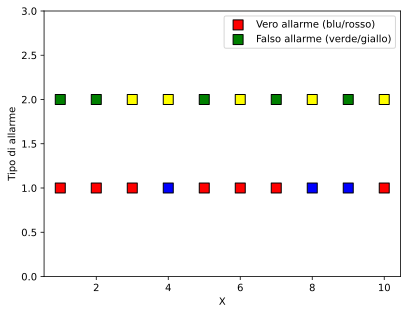

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Dati di esempio
x = np.arange(1, 11)  # Asse X con 10 punti

# Definiamo quali allarmi sono veri e quali falsi
true_alarms = np.random.choice([0, 1], size=len(x))  # 0 per rosso, 1 per blu
false_alarms = np.random.choice([0, 1], size=len(x))  # 0 per giallo, 1 per verde

# Creazione della figura e dell'asse
fig, ax = plt.subplots()

# Plot dei "veri allarmi" in y=1
ax.scatter(x, np.ones_like(x), c=['blue' if ta == 1 else 'red' for ta in true_alarms], 
           marker='s', s=100, label='Vero allarme (blu/rosso)', edgecolor='black')

# Plot dei "falsi allarmi" in y=2
ax.scatter(x, np.ones_like(x)*2, c=['green' if fa == 1 else 'yellow' for fa in false_alarms], 
           marker='s', s=100, label='Falso allarme (verde/giallo)', edgecolor='black')

# Aggiungi etichette agli assi
ax.set_xlabel('X')
ax.set_ylabel('Tipo di allarme')

# Imposta i limiti per l'asse Y
ax.set_ylim(0, 3)

# Aggiungi una legenda
ax.legend()

# Mostra il grafico
plt.show()
